In [114]:
# imports
import torch
from torch import nn
from torch.nn import functional as F

import math
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
from datetime import datetime as dt
import os

import pickle as pkl

In [115]:
# set seed
_ = torch.manual_seed(13)

In [116]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cpu')

In [117]:
transform = transforms.ToTensor()

train_set = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, num_workers=0
)

## Visualize the data

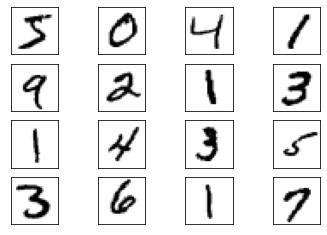

In [118]:
real_samples, mnist = next(iter(train_loader))
for (index, image) in enumerate(real_samples[0:16]):
    ax = plt.subplot(4, 4, index + 1)
    plt.imshow(image.reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

## Models

In [119]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # hidden layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = self.fc4(x)

        return out


class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = torch.tanh(self.fc4(x))

        return out

## Hyper Params

In [120]:
input_size = 784
d_output_size = 1
d_hidden_size = 32

z_size = 100
g_output_size = 784
g_hidden_size = 32

In [121]:
D = Discriminator(input_size, d_hidden_size, d_output_size).to(device=device)
G = Generator(z_size, g_hidden_size, g_output_size).to(device=device)

## Losses

In [122]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) 
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [123]:
lr = 0.002

d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

## Saving and loading functions

In [124]:
def save_checkpoint(state, is_best, checkpoint_dir):
    file_path = f"{checkpoint_dir}/checkpoint.pt"
    torch.save(state, file_path)
    if is_best: 
        best_fpath = f"{checkpoint_dir}/best_model.pt"
        torch.save(state, best_fpath)

## Training

In [125]:
# Change this for whether we should load or not
load_checkpoint = False

In [127]:
start_at_epoch = 1
num_epochs = 500

samples = []
losses = []

print_every = 400

sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

load_path = "./model/2021-05-26T13:28:18/checkpoint.pt"

if load_checkpoint: 
    checkpoint = torch.load(load_path)
    G.load_state_dict(checkpoint["gen_state_dict"])
    D.load_state_dict(checkpoint["disc_state_dict"])
    g_optimizer.load_state_dict(checkpoint["gen_optim_state_dict"])
    d_optimizer.load_state_dict(checkpoint["disc_optim_state_dict"])
    start_at_epoch = checkpoint["epoch"] + 1
    print("Checkpoint loaded")
else:
    print("Starting from beginning")

Starting from beginning


In [128]:
now = dt.now()
stamp = now.strftime("%Y-%m-%dT%H:%M:%S")
path = f"model/{stamp}"
os.mkdir(path)

best_g_loss = math.inf

D.train()
G.train()
for epoch in range(start_at_epoch, start_at_epoch + num_epochs):
    
    epoch_start_time = time.time()

    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs + start_at_epoch, d_loss.item(), g_loss.item()))
            
    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode
    
    # Save training generator samples
    with open(f"{path}/train_samples.pkl", 'wb') as f:
        pkl.dump(samples, f)
        
    # Save checkpoint
    if g_loss.item() < best_g_loss:
        best_g_loss = g_loss.item()
        best_model = True
    else:
        best_model = False
    state = {
        "epoch": epoch,
        "gen_state_dict": G.state_dict(),
        "disc_state_dict": D.state_dict(),
        "gen_optim_state_dict": g_optimizer.state_dict(),
        "disc_optim_state_dict": d_optimizer.state_dict(),
        "gen_loss": g_loss,
        "disc_loss": d_loss,
    }
    save_checkpoint(state, best_model, path)
    
    
    # print time
    print(f"Time for epoch: {time.time() - epoch_start_time}")

Epoch [    2/  501] | d_loss: 1.3448 | g_loss: 0.7306
Epoch [    2/  501] | d_loss: 0.5774 | g_loss: 4.3326
Epoch [    2/  501] | d_loss: 0.6898 | g_loss: 3.9163
Time for epoch: 10.263183355331421
Epoch [    3/  501] | d_loss: 1.4604 | g_loss: 1.3780
Epoch [    3/  501] | d_loss: 1.1728 | g_loss: 1.2314
Epoch [    3/  501] | d_loss: 1.0551 | g_loss: 1.5102
Time for epoch: 9.746163606643677
Epoch [    4/  501] | d_loss: 1.0904 | g_loss: 1.7959
Epoch [    4/  501] | d_loss: 1.2277 | g_loss: 1.0165
Epoch [    4/  501] | d_loss: 1.1520 | g_loss: 1.1204
Time for epoch: 9.916306257247925
Epoch [    5/  501] | d_loss: 1.0189 | g_loss: 1.8882
Epoch [    5/  501] | d_loss: 1.0093 | g_loss: 1.5216
Epoch [    5/  501] | d_loss: 1.0858 | g_loss: 1.9877
Time for epoch: 9.958605527877808
Epoch [    6/  501] | d_loss: 0.9467 | g_loss: 2.1833
Epoch [    6/  501] | d_loss: 1.0991 | g_loss: 1.5012
Epoch [    6/  501] | d_loss: 1.2390 | g_loss: 1.6618
Time for epoch: 10.14488959312439
Epoch [    7/  501]

Time for epoch: 10.223850011825562
Epoch [   44/  501] | d_loss: 1.3166 | g_loss: 1.2901
Epoch [   44/  501] | d_loss: 1.4056 | g_loss: 1.0769
Epoch [   44/  501] | d_loss: 1.2801 | g_loss: 0.9906
Time for epoch: 10.845312595367432
Epoch [   45/  501] | d_loss: 1.3580 | g_loss: 0.9431
Epoch [   45/  501] | d_loss: 1.3100 | g_loss: 0.9391
Epoch [   45/  501] | d_loss: 1.3601 | g_loss: 0.9951
Time for epoch: 9.870314121246338
Epoch [   46/  501] | d_loss: 1.1834 | g_loss: 1.2523
Epoch [   46/  501] | d_loss: 1.3079 | g_loss: 1.3897
Epoch [   46/  501] | d_loss: 1.3079 | g_loss: 0.9227
Time for epoch: 9.56320071220398
Epoch [   47/  501] | d_loss: 1.2939 | g_loss: 0.9717
Epoch [   47/  501] | d_loss: 1.2906 | g_loss: 0.9238
Epoch [   47/  501] | d_loss: 1.3523 | g_loss: 1.1515
Time for epoch: 9.263495922088623
Epoch [   48/  501] | d_loss: 1.3306 | g_loss: 0.9343
Epoch [   48/  501] | d_loss: 1.3200 | g_loss: 0.9232
Epoch [   48/  501] | d_loss: 1.2478 | g_loss: 1.3025
Time for epoch: 9.6

Time for epoch: 9.071109771728516
Epoch [   86/  501] | d_loss: 1.2892 | g_loss: 0.9661
Epoch [   86/  501] | d_loss: 1.2888 | g_loss: 1.0250
Epoch [   86/  501] | d_loss: 1.3205 | g_loss: 1.0214
Time for epoch: 9.24958610534668
Epoch [   87/  501] | d_loss: 1.1977 | g_loss: 0.9588
Epoch [   87/  501] | d_loss: 1.2374 | g_loss: 0.8211
Epoch [   87/  501] | d_loss: 1.3274 | g_loss: 1.1107
Time for epoch: 9.722047328948975
Epoch [   88/  501] | d_loss: 1.2473 | g_loss: 1.0034
Epoch [   88/  501] | d_loss: 1.2072 | g_loss: 1.1506
Epoch [   88/  501] | d_loss: 1.2973 | g_loss: 0.8946
Time for epoch: 9.606841325759888
Epoch [   89/  501] | d_loss: 1.4365 | g_loss: 1.3988
Epoch [   89/  501] | d_loss: 1.2746 | g_loss: 0.8181
Epoch [   89/  501] | d_loss: 1.3916 | g_loss: 1.0142
Time for epoch: 10.17096734046936
Epoch [   90/  501] | d_loss: 1.2808 | g_loss: 0.9432
Epoch [   90/  501] | d_loss: 1.3444 | g_loss: 0.8864
Epoch [   90/  501] | d_loss: 1.3544 | g_loss: 0.9329
Time for epoch: 10.00

Time for epoch: 9.487077236175537
Epoch [  128/  501] | d_loss: 1.3439 | g_loss: 0.8738
Epoch [  128/  501] | d_loss: 1.1265 | g_loss: 1.4637
Epoch [  128/  501] | d_loss: 1.2946 | g_loss: 0.9962
Time for epoch: 9.396832466125488
Epoch [  129/  501] | d_loss: 1.2744 | g_loss: 0.9060
Epoch [  129/  501] | d_loss: 1.2660 | g_loss: 1.1269
Epoch [  129/  501] | d_loss: 1.2527 | g_loss: 1.0765
Time for epoch: 9.410253047943115
Epoch [  130/  501] | d_loss: 1.3076 | g_loss: 0.9160
Epoch [  130/  501] | d_loss: 1.2434 | g_loss: 0.9683
Epoch [  130/  501] | d_loss: 1.4117 | g_loss: 1.1304
Time for epoch: 9.728297472000122
Epoch [  131/  501] | d_loss: 1.2820 | g_loss: 0.9628
Epoch [  131/  501] | d_loss: 1.1967 | g_loss: 0.9338
Epoch [  131/  501] | d_loss: 1.2901 | g_loss: 1.0329
Time for epoch: 9.908636331558228
Epoch [  132/  501] | d_loss: 1.2278 | g_loss: 0.8267
Epoch [  132/  501] | d_loss: 1.2899 | g_loss: 0.9297
Epoch [  132/  501] | d_loss: 1.2574 | g_loss: 1.0661
Time for epoch: 9.73

Epoch [  169/  501] | d_loss: 1.3642 | g_loss: 1.0140
Time for epoch: 9.633951902389526
Epoch [  170/  501] | d_loss: 1.2334 | g_loss: 1.1388
Epoch [  170/  501] | d_loss: 1.2629 | g_loss: 1.1575
Epoch [  170/  501] | d_loss: 1.2400 | g_loss: 1.0668
Time for epoch: 10.86914348602295
Epoch [  171/  501] | d_loss: 1.2771 | g_loss: 0.8652
Epoch [  171/  501] | d_loss: 1.2665 | g_loss: 0.9799
Epoch [  171/  501] | d_loss: 1.3175 | g_loss: 0.8486
Time for epoch: 10.211160898208618
Epoch [  172/  501] | d_loss: 1.1507 | g_loss: 1.5837
Epoch [  172/  501] | d_loss: 1.1888 | g_loss: 1.2636
Epoch [  172/  501] | d_loss: 1.3427 | g_loss: 0.9531
Time for epoch: 11.329707622528076
Epoch [  173/  501] | d_loss: 1.3260 | g_loss: 0.9352
Epoch [  173/  501] | d_loss: 1.2301 | g_loss: 1.0220
Epoch [  173/  501] | d_loss: 1.3452 | g_loss: 1.1531
Time for epoch: 10.359686851501465
Epoch [  174/  501] | d_loss: 1.3362 | g_loss: 0.8414
Epoch [  174/  501] | d_loss: 1.2084 | g_loss: 1.2168
Epoch [  174/  50

Epoch [  211/  501] | d_loss: 1.3640 | g_loss: 1.0939
Time for epoch: 8.79551100730896
Epoch [  212/  501] | d_loss: 1.1851 | g_loss: 1.9131
Epoch [  212/  501] | d_loss: 1.2010 | g_loss: 1.1015
Epoch [  212/  501] | d_loss: 1.3905 | g_loss: 1.0851
Time for epoch: 9.497868061065674
Epoch [  213/  501] | d_loss: 1.2448 | g_loss: 1.1443
Epoch [  213/  501] | d_loss: 1.1885 | g_loss: 1.1084
Epoch [  213/  501] | d_loss: 1.4168 | g_loss: 0.9490
Time for epoch: 9.376320600509644
Epoch [  214/  501] | d_loss: 1.4795 | g_loss: 0.8534
Epoch [  214/  501] | d_loss: 1.2077 | g_loss: 1.0329
Epoch [  214/  501] | d_loss: 1.3941 | g_loss: 1.1314
Time for epoch: 8.789667844772339
Epoch [  215/  501] | d_loss: 1.2303 | g_loss: 1.1385
Epoch [  215/  501] | d_loss: 1.2265 | g_loss: 1.0001
Epoch [  215/  501] | d_loss: 1.4238 | g_loss: 1.4344
Time for epoch: 8.792948007583618
Epoch [  216/  501] | d_loss: 1.3258 | g_loss: 1.0358
Epoch [  216/  501] | d_loss: 1.2205 | g_loss: 0.9273
Epoch [  216/  501] |

Epoch [  253/  501] | d_loss: 1.4697 | g_loss: 1.1016
Time for epoch: 8.887652158737183
Epoch [  254/  501] | d_loss: 1.3165 | g_loss: 1.1137
Epoch [  254/  501] | d_loss: 1.2044 | g_loss: 0.9734
Epoch [  254/  501] | d_loss: 1.3756 | g_loss: 1.0106
Time for epoch: 8.840059280395508
Epoch [  255/  501] | d_loss: 1.2119 | g_loss: 1.0764
Epoch [  255/  501] | d_loss: 1.1369 | g_loss: 1.2481
Epoch [  255/  501] | d_loss: 1.3702 | g_loss: 1.1068
Time for epoch: 8.888739347457886
Epoch [  256/  501] | d_loss: 1.2304 | g_loss: 1.4051
Epoch [  256/  501] | d_loss: 1.2270 | g_loss: 0.9666
Epoch [  256/  501] | d_loss: 1.2804 | g_loss: 1.0137
Time for epoch: 9.557341575622559
Epoch [  257/  501] | d_loss: 1.2306 | g_loss: 1.2544
Epoch [  257/  501] | d_loss: 1.3073 | g_loss: 0.9493
Epoch [  257/  501] | d_loss: 1.3307 | g_loss: 1.2756
Time for epoch: 9.385193347930908
Epoch [  258/  501] | d_loss: 1.2963 | g_loss: 1.0274
Epoch [  258/  501] | d_loss: 1.3043 | g_loss: 1.0159
Epoch [  258/  501] 

Epoch [  295/  501] | d_loss: 1.3198 | g_loss: 1.4915
Time for epoch: 10.82073974609375
Epoch [  296/  501] | d_loss: 1.1975 | g_loss: 1.2461
Epoch [  296/  501] | d_loss: 1.2969 | g_loss: 1.3397
Epoch [  296/  501] | d_loss: 1.3180 | g_loss: 1.0100
Time for epoch: 12.150181293487549
Epoch [  297/  501] | d_loss: 1.1893 | g_loss: 1.2512
Epoch [  297/  501] | d_loss: 1.2225 | g_loss: 1.4717
Epoch [  297/  501] | d_loss: 1.3213 | g_loss: 1.0245
Time for epoch: 10.217168807983398
Epoch [  298/  501] | d_loss: 1.1869 | g_loss: 1.1421
Epoch [  298/  501] | d_loss: 1.2663 | g_loss: 1.1541
Epoch [  298/  501] | d_loss: 1.3087 | g_loss: 0.9936
Time for epoch: 9.881369352340698
Epoch [  299/  501] | d_loss: 1.3126 | g_loss: 0.9328
Epoch [  299/  501] | d_loss: 1.2027 | g_loss: 0.9174
Epoch [  299/  501] | d_loss: 1.3029 | g_loss: 1.0275
Time for epoch: 9.748347997665405
Epoch [  300/  501] | d_loss: 1.1876 | g_loss: 1.2700
Epoch [  300/  501] | d_loss: 1.2949 | g_loss: 1.1443
Epoch [  300/  501

Epoch [  337/  501] | d_loss: 1.3296 | g_loss: 1.1984
Epoch [  337/  501] | d_loss: 1.3473 | g_loss: 1.0787
Time for epoch: 10.465218544006348
Epoch [  338/  501] | d_loss: 1.2165 | g_loss: 1.5309
Epoch [  338/  501] | d_loss: 1.2256 | g_loss: 1.1864
Epoch [  338/  501] | d_loss: 1.3006 | g_loss: 1.0022
Time for epoch: 10.521617412567139
Epoch [  339/  501] | d_loss: 1.1091 | g_loss: 1.2231
Epoch [  339/  501] | d_loss: 1.3174 | g_loss: 1.0227
Epoch [  339/  501] | d_loss: 1.3368 | g_loss: 1.0314
Time for epoch: 11.222160816192627
Epoch [  340/  501] | d_loss: 1.2226 | g_loss: 1.1250
Epoch [  340/  501] | d_loss: 1.2586 | g_loss: 1.0329
Epoch [  340/  501] | d_loss: 1.2547 | g_loss: 0.9676
Time for epoch: 12.354958772659302
Epoch [  341/  501] | d_loss: 1.3164 | g_loss: 0.9657
Epoch [  341/  501] | d_loss: 1.1753 | g_loss: 1.0693
Epoch [  341/  501] | d_loss: 1.3006 | g_loss: 0.9696
Time for epoch: 14.010854721069336
Epoch [  342/  501] | d_loss: 1.1947 | g_loss: 1.1875
Epoch [  342/  

Epoch [  379/  501] | d_loss: 1.2088 | g_loss: 1.2393
Epoch [  379/  501] | d_loss: 1.1863 | g_loss: 1.0407
Time for epoch: 9.495187520980835
Epoch [  380/  501] | d_loss: 1.2544 | g_loss: 1.7344
Epoch [  380/  501] | d_loss: 1.2835 | g_loss: 1.0338
Epoch [  380/  501] | d_loss: 1.2345 | g_loss: 1.2976
Time for epoch: 9.11688780784607
Epoch [  381/  501] | d_loss: 1.1950 | g_loss: 1.2751
Epoch [  381/  501] | d_loss: 1.2663 | g_loss: 1.1585
Epoch [  381/  501] | d_loss: 1.1897 | g_loss: 1.1308
Time for epoch: 10.096307516098022
Epoch [  382/  501] | d_loss: 1.1961 | g_loss: 1.1904
Epoch [  382/  501] | d_loss: 1.3874 | g_loss: 1.6363
Epoch [  382/  501] | d_loss: 1.3092 | g_loss: 1.0960
Time for epoch: 10.015939474105835
Epoch [  383/  501] | d_loss: 1.1736 | g_loss: 1.5097
Epoch [  383/  501] | d_loss: 1.1775 | g_loss: 1.2243
Epoch [  383/  501] | d_loss: 1.2383 | g_loss: 1.2059
Time for epoch: 9.93844747543335
Epoch [  384/  501] | d_loss: 1.2629 | g_loss: 1.8115
Epoch [  384/  501] 

Epoch [  421/  501] | d_loss: 1.1475 | g_loss: 1.2033
Epoch [  421/  501] | d_loss: 1.2260 | g_loss: 0.9825
Time for epoch: 9.526099920272827
Epoch [  422/  501] | d_loss: 1.1884 | g_loss: 1.4040
Epoch [  422/  501] | d_loss: 1.0912 | g_loss: 1.0478
Epoch [  422/  501] | d_loss: 1.3301 | g_loss: 1.1549
Time for epoch: 10.092422246932983
Epoch [  423/  501] | d_loss: 1.1919 | g_loss: 1.2445
Epoch [  423/  501] | d_loss: 1.3514 | g_loss: 1.2381
Epoch [  423/  501] | d_loss: 1.3713 | g_loss: 1.2677
Time for epoch: 9.907365560531616
Epoch [  424/  501] | d_loss: 1.0831 | g_loss: 1.3179
Epoch [  424/  501] | d_loss: 1.1675 | g_loss: 0.9977
Epoch [  424/  501] | d_loss: 1.2974 | g_loss: 0.9733
Time for epoch: 9.784202575683594
Epoch [  425/  501] | d_loss: 1.1197 | g_loss: 1.7073
Epoch [  425/  501] | d_loss: 1.2023 | g_loss: 1.9267
Epoch [  425/  501] | d_loss: 1.1926 | g_loss: 1.0468
Time for epoch: 9.864018440246582
Epoch [  426/  501] | d_loss: 1.1850 | g_loss: 1.2713
Epoch [  426/  501]

Epoch [  463/  501] | d_loss: 1.1714 | g_loss: 1.2854
Epoch [  463/  501] | d_loss: 1.3422 | g_loss: 1.1613
Time for epoch: 9.816306591033936
Epoch [  464/  501] | d_loss: 1.2671 | g_loss: 1.3703
Epoch [  464/  501] | d_loss: 1.1588 | g_loss: 1.2500
Epoch [  464/  501] | d_loss: 1.2998 | g_loss: 1.1959
Time for epoch: 9.874365091323853
Epoch [  465/  501] | d_loss: 1.1749 | g_loss: 1.3178
Epoch [  465/  501] | d_loss: 1.1783 | g_loss: 1.3393
Epoch [  465/  501] | d_loss: 1.2527 | g_loss: 1.1854
Time for epoch: 9.137876510620117
Epoch [  466/  501] | d_loss: 1.1158 | g_loss: 1.3376
Epoch [  466/  501] | d_loss: 1.2464 | g_loss: 1.6435
Epoch [  466/  501] | d_loss: 1.3262 | g_loss: 1.3582
Time for epoch: 9.210325241088867
Epoch [  467/  501] | d_loss: 1.3100 | g_loss: 1.4331
Epoch [  467/  501] | d_loss: 1.1537 | g_loss: 1.1906
Epoch [  467/  501] | d_loss: 1.2531 | g_loss: 1.1508
Time for epoch: 9.529900312423706
Epoch [  468/  501] | d_loss: 1.1816 | g_loss: 1.3394
Epoch [  468/  501] 

## Plot Training Loss

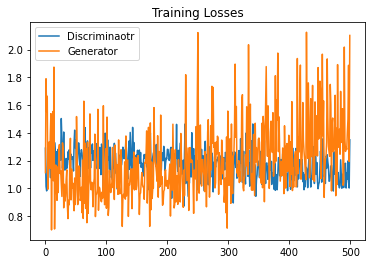

In [129]:
fig, ax = plt.subplots()
np_losses = np.array(losses)
plt.plot(np_losses.T[0], label="Discriminaotr")
plt.plot(np_losses.T[1], label="Generator")
plt.title("Training Losses")
plt.legend()

In [130]:
kkk

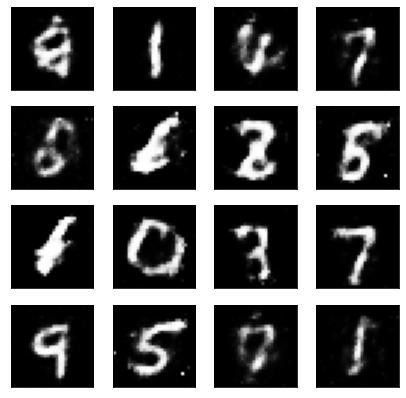

In [131]:
view_samples(-1, samples)

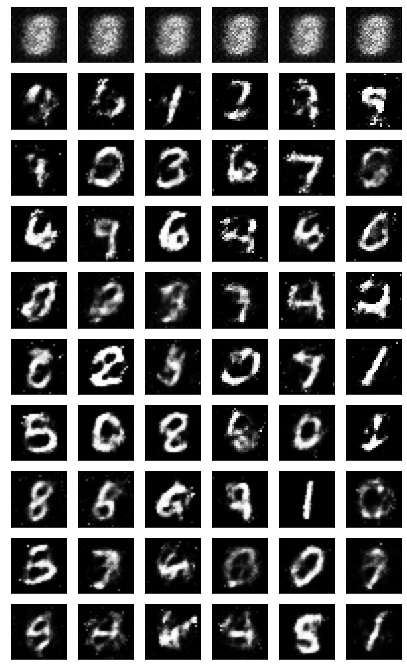

In [132]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)


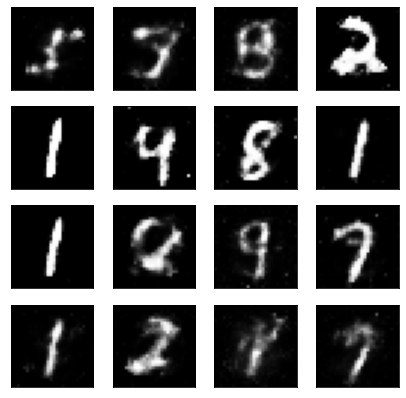

In [112]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

## Export Losses

In [158]:
losses_path = f"{path}/losses.json"
with open(losses_path, "w") as f:
    f.write(json.dumps(losses))